### Running a GLM using a `poisson` distribution 

In [1]:
## Adding code from the pymc3 documentation

%matplotlib inline
import sys
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
import seaborn as sns
import patsy as pt
import pymc3 as pm

plt.rcParams['figure.figsize'] = 14, 6
np.random.seed(0)
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.2


#### Adding Local functions (based on the example code)

In [2]:
def strip_derived_rvs(rvs):
    '''Convenience fn: remove PyMC3-generated RVs from a list'''
    ret_rvs = []
    for rv in rvs:
        if not (re.search('_log',rv.name) or re.search('_interval',rv.name)):
            ret_rvs.append(rv)
    return ret_rvs


def plot_traces_pymc(trcs, varnames=None):
    ''' Convenience fn: plot traces with overlaid means and values '''

    nrows = len(trcs.varnames)
    if varnames is not None:
        nrows = len(varnames)

    ax = pm.traceplot(trcs, varnames=varnames, figsize=(12,nrows*1.4),
                      lines={k: v['mean'] for k, v in
                             pm.summary(trcs,varnames=varnames).iterrows()})

    for i, mn in enumerate(pm.summary(trcs, varnames=varnames)['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data',
                         xytext=(5,10), textcoords='offset points', rotation=90,
                         va='bottom', fontsize='large', color='#AA0022')

### Generating some data

In this assignment, I will be using a `poisson` distribution to identify the detectability of a species, given the presence/absence of a particular species along and not along an elevational gradient. 

In [21]:
# decide poisson theta values

theta_nospecies_elevation = 1    # absence, elevational gradient
theta_species_elevation = 3      # presence, elevational gradient
theta_nospecies_noelevation = 6  # absence, not along an elevational gradient
theta_species_noelevation = 36   # , no antihist

# create samples
q = 1000
df = pd.DataFrame({
        'detectability': np.concatenate((np.random.poisson(theta_nospecies_elevation, q),
                                   np.random.poisson(theta_species_elevation, q),
                                   np.random.poisson(theta_nospecies_noelevation, q),
                                   np.random.poisson(theta_species_noelevation, q))),
        'species': np.concatenate((np.repeat(False, q),
                                   np.repeat(True, q),
                                   np.repeat(False, q),
                                   np.repeat(True, q))),
        'elevation': np.concatenate((np.repeat(False, q),
                                      np.repeat(False, q),
                                      np.repeat(True, q),
                                      np.repeat(True, q)))})

In [22]:
df.tail()

,detectability,elevation,species
3995,37,True,True
3996,36,True,True
3997,33,True,True
3998,29,True,True
3999,25,True,True


View the means of the various combinations (Poisson mean values)

In [23]:
df.groupby(['species','elevation']).mean().unstack()

detectability        
elevation         False   True 
species                        
False             1.002   5.982
True              2.984  36.273

Describing the dataset

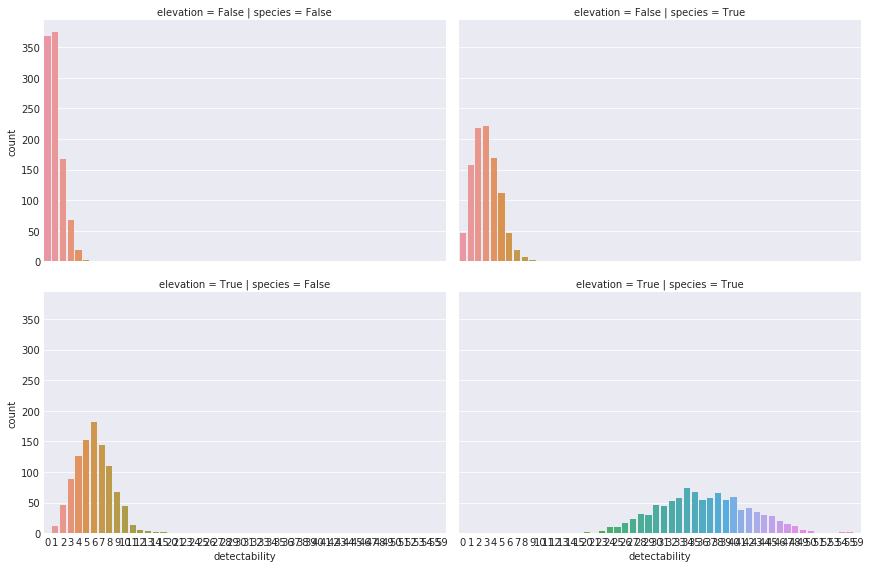

In [24]:
g = sns.factorplot(x='detectability', row='elevation', col='species', data=df,
               kind='count', size=4, aspect=1.5)

## Creating a linear model depicting interaction of terms

In [25]:
fml = 'detectability ~ species + elevation + species:elevation'

### Running a model with `pymc.glm`

In [26]:
with pm.Model() as mdl_fish_alt:

    pm.glm.GLM.from_formula(fml, df, family=pm.glm.families.Poisson())

In [27]:
with mdl_fish_alt:
    trc_fish_alt = pm.sample(4000, tune=2000)[2000:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 6000/6000 [01:20<00:00, 74.87it/s]


In [28]:
rvs_fish_alt = [rv.name for rv in strip_derived_rvs(mdl_fish_alt.unobserved_RVs)]
plot_traces_pymc(trc_fish_alt, varnames=rvs_fish_alt)


Intercept:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.001            0.030            0.001            [-0.051, 0.064]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.058         -0.020         0.002          0.022          0.058


species[T.True]:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1.093            0.035            0.002            [1.028, 1.160]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  1.028          1.068          1.092          1.116          1.160


elevation[T.True]:

  Mean             SD               MC Error         95% HPD interval


AttributeError: 'NoneType' object has no attribute 'iterrows'

In [29]:
np.exp(pm.summary(trc_fish_alt, varnames=rvs_fish_alt)[['mean','hpd_2.5','hpd_97.5']])


Intercept:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.001            0.030            0.001            [-0.051, 0.064]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.058         -0.020         0.002          0.022          0.058


species[T.True]:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1.093            0.035            0.002            [1.028, 1.160]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  1.028          1.068          1.092          1.116          1.160


elevation[T.True]:

  Mean             SD               MC Error         95% HPD interval


TypeError: 'NoneType' object is not subscriptable

In [30]:
np.percentile(trc_fish_alt['mu'], [25,50,75])

array([  4.13531231,  10.46610261,  24.83840813])

In [31]:
df['detectability'].mean()

11.56025

From this exercise, we note that the simulated mean is very very close to the overall mean of detecting a particular species. Essentially this means that the model does a decent job at detecting a particular species. 

1. The parameters are within the 95% confidence interval
2. Unfortunately the trace plot did not work, but the summary worked. 
3. I tried to seek help on the same, through online portals, but I am obtaining this `nonetype error`
4. I think the MCMC sampler ran long enough. 